# Course project - IMDB movie rating
### Name: ZHANG Yaxin, No.:20661795
The code has been uploaded to: https://github.com/Yesenia024/IMDB-movie-sentiment-analysis

## Table of Contents
* 1. Introduction
* 2. Data processing
* 3. Model building and results
* 4. Evaluation and summary
* 5. Acknowledge and reference

## 1. Introduction

This notebook studies the binary classification problem. The data is an IMDB dataset of 50,000 movie reviews, which includes 25,000 training data and 25,000 test data. This article uses classification algorithms including logistic regression to get different models and compare the results of each model.

## 2. Data processing

At the beginning, we first load some basic libraries we use.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
# To deal with non-standard words
import re 
from bs4 import BeautifulSoup

We load data from the following link: http://ai.stanford.edu/~amaas/data/sentiment/
The data includes two folders, train and test, and each folder contains two folders, neg and pos. The comments are stored as separate files in txt format.
Therefore, we must first import the data from these texts and define the following functions:

In [2]:
# Load data from these folders
# define a function for gathering reviews from single file one by one, and append them together as a Dataframe.
# label: 'pos' or 'neg' 
def folders_download(data, label):
    sentence = []
    for filepath in os.listdir('aclImdb/' + data + '/' + label):
        with open(('aclImdb/' + data + '/' + label + '/' + filepath), 'r', encoding='UTF-8') as file:
            review = file.read()
            sentence.append(review)
    if label == 'pos':
        sentiment = 1  
    else:
        sentiment = 0
    reviews = pd.Series(sentence)
    reviews = pd.DataFrame({'review': reviews})
    reviews['sentiment'] = pd.Series(np.array([sentiment] * len(reviews)), index=reviews.index)
    return reviews
# define a function for appending 'pos' and 'neg' reviews 
# data: string
def append_together(data):
    pos = folders_download(data, 'pos')
    neg = folders_download(data, 'neg')
    data = pd.DataFrame(pos)
    data = data.append(neg, ignore_index=True)
    print("Import data is completed.")
    return data

Now, let's import the training set and test set respectively, named train and test. And simply look at what the train looks like.

In [3]:
train = append_together('train')
test = append_together('test')
train

Import data is completed.
Import data is completed.


,review,sentiment
0,Bromwell High is a cartoon comedy. It ran at t...,1
1,Homelessness (or Houselessness as George Carli...,1
2,Brilliant over-acting by Lesley Ann Warren. Be...,1
3,This is easily the most underrated film inn th...,1
4,This is not the typical Mel Brooks film. It wa...,1
...,...,...
24995,"Towards the end of the movie, I felt it was to...",0
24996,This is the kind of movie that my enemies cont...,0
24997,I saw 'Descent' last night at the Stockholm Fi...,0
24998,Some films that you pick up for a pound turn o...,0


As you can see, train is a 25000-line dataframe. Before we clean the text, let's take a look at the degree of cleaning in these reviews. Take the second line of text as an example:

In [4]:
train.review[1]

'Homelessness (or Houselessness as George Carlin stated) has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school, work, or vote for the matter. Most people think of the homeless as just a lost cause while worrying about things such as racism, the war on Iraq, pressuring kids to succeed, technology, the elections, inflation, or worrying if they\'ll be next to end up on the streets.<br /><br />But what if you were given a bet to live on the streets for a month without the luxuries you once had from a home, the entertainment sets, a bathroom, pictures on the wall, a computer, and everything you once treasure to see what it\'s like to be homeless? That is Goddard Bolt\'s lesson.<br /><br />Mel Brooks (who directs) who stars as Bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival (Jeffery Tambor) to see if he can live in the streets for thirty days withou

It can be seen that these reviews are the raw data obtained after crawling the data, we need to remove HTML tags (<br/), handle non-standard words and change uppercase to lowercase. Define the following function to perform these operations.

In [5]:
def data_processing(review):
    review = BeautifulSoup(review, "html.parser").get_text()
    review = re.sub("[^a-zA-Z]"," ", review)
    review = review.lower().split()
    return review

Separate the dependent and independent variables of the data, and do data cleaning on the independent variables. The processing results are shown below.

In [6]:
y_train = train['sentiment']
y_test = test['sentiment']
X_train = []
for i in range(len(train['review'])):
    X_train.append(' '.join(data_processing(train['review'][i])))
X_test = []
for i in range(len(test['review'])):
    X_test.append(' '.join(data_processing(test['review'][i])))
print("Text data is processed.")
X_train[1]

Text data is processed.


'homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter most people think of the homeless as just a lost cause while worrying about things such as racism the war on iraq pressuring kids to succeed technology the elections inflation or worrying if they ll be next to end up on the streets but what if you were given a bet to live on the streets for a month without the luxuries you once had from a home the entertainment sets a bathroom pictures on the wall a computer and everything you once treasure to see what it s like to be homeless that is goddard bolt s lesson mel brooks who directs who stars as bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival jeffery tambor to see if he can live in the streets for thirty days without the luxuries if bolt succeeds he can do what h

To delete certain stop words and convert text data into numeric values, use TFIDF to do that.
Because the processing results of different data will be different, we need to process the training set and test set together to ensure the consistency of the processing results.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer as TFIDF
tfidf = TFIDF(min_df=2, 
           max_features=None,
           strip_accents='unicode',
           analyzer='word',
           token_pattern=r'\w{1,}',
           ngram_range=(1, 3),  
           use_idf=1,
           smooth_idf=1,
           sublinear_tf=1,
           stop_words = 'english') 
data_all = X_train + X_test
len_train = len(X_train)
tfidf.fit(data_all)
data_all = tfidf.transform(data_all)
X_train = data_all[:len_train]
X_test = data_all[len_train:]
print ("TF-IDF is completed.")

TF-IDF is completed.


In [8]:
X_train

<25000x810864 sparse matrix of type '<class 'numpy.float64'>'
	with 4044672 stored elements in Compressed Sparse Row format>

So far, we have processed the data. The independent variable is a large sparse matrix, and the dependent variable is a binary variable of 0 or 1. Below, different models are built for this classification problem:
## 3. Model building and results
I use the cross-validation method by choosing k=10 and import some libraries.

In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc  

### Logistic Regression

In [10]:
logmodel = LogisticRegression() 
logmodel.fit(X_train,y_train)
logpred = logmodel.predict(X_test)
print(confusion_matrix(y_test, logpred))
print(round(accuracy_score(y_test, logpred),2)*100)
LR_CV = (cross_val_score(logmodel, X_train, y_train, cv=k_fold, n_jobs=1, scoring = 'accuracy').mean())

[[10938  1562]
 [ 1413 11087]]
88.0


### Decision Tree Classifier

In [11]:
dtree = DecisionTreeClassifier(criterion='gini') # criterion = entopy, gini
dtree.fit(X_train, y_train)
dtreepred = dtree.predict(X_test)
print(confusion_matrix(y_test, dtreepred))
print(round(accuracy_score(y_test, dtreepred),2)*100)
DT_CV = recall_score(y_test, dtreepred)

[[8884 3616]
 [3691 8809]]
71.0


### XGB Classifier

In [12]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgbprd = xgb.predict(X_test)
print(confusion_matrix(y_test, xgbprd ))
print(round(accuracy_score(y_test, xgbprd),2)*100)
XGB_CV = recall_score(y_test, xgbprd)

[[10386  2114]
 [ 1729 10771]]
85.0


### K-Neighbors Classifier

In [17]:
'''
By observing K from 1 to 90, the result of cross-validation increased from more than 40 to 65,
and it grew steadily, without obvious peaks. Because the K value is too large, it is not good, so choose K=45.
'''
knn = KNeighborsClassifier(n_neighbors=45)
knn.fit(X_train, y_train)
knnpred = knn.predict(X_test)
print(confusion_matrix(y_test, knnpred))
print(round(accuracy_score(y_test, knnpred),2)*100)
KNN_CV = recall_score(y_test, knnpred)

[[10097  2403]
 [ 2801  9699]]
79.0


## 4. Evaluation and summary

In [21]:
models = pd.DataFrame({
                'Models': ['Decision Tree Classifier', 'Logistic Model',  'XGBoost','KNN'],
                'Recall Score':  [DT_CV,  LR_CV, XGB_CV, KNN_CV ]})
models.sort_values(by='Recall Score', ascending=False)

,Models,Recall Score
1,Logistic Model,0.88768
2,XGBoost,0.86168
3,KNN,0.77592
0,Decision Tree Classifier,0.70472


This semester, my professor talked about many models. I only selected 4 representative and more suitable ones. I did not choose a model like Naive Bayes because the variables are sparse matrices.

It can be seen that the result of 'Logistic Model' is the best, which shows that it performs well when dealing with large and sparse independent variables. In addition, its best performance also illustrates a point: sometimes complex models do not mean performance Improvement.

The'XGBoost' ranks second because it is an optimization of the gradient boost model and has good performance, followed by'KNN', because the word matrix is huge, it may affect the performance of KNN, and the last one is the basic'Decision Tree Classifier ', which is expected.

Next, let's take a look at the ROC curve and AUC value of the model. Taking only the best model'Logistic Model' as an example, the rest can be obtained by uncommenting, and the following functions are defined:

In [42]:
def plot_ROC(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    fig = plt.gcf()
    plt.title('Receiver Operating Characteristic Curve', fontsize=15)
    plt.plot(false_positive_rate,true_positive_rate, 'b', label='AUC = %0.2f' % roc_auc) #AUC
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('True Positive Rate', fontsize=15)
    plt.xlabel('False Positive Rate', fontsize=15)
    fig.set_size_inches(8, 6)
    plt.show()

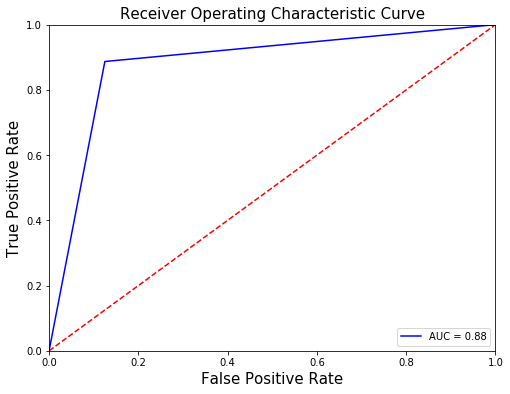

In [43]:
plot_ROC(y_test, logpred)
#plot_ROC(y_test, dtreepred)
#plot_ROC(y_test, xgbprd)
#plot_ROC(y_test, knnpred)

We can see that although the ROC curve is not smooth, when the false positive rate is around 0.1, the true positive rate has reached 0.9. Moreover, generally we don’t like the fact that it is false, but the prediction is true. And this curve is on the left, which means that when the false positive rate is low, the true positive rate is relatively high, which is what we welcome.
where,
$$ false\ positive\ rate = \cfrac{false\ positive}{(false\ positive + true\ negative}),$$
$$ true\ positive\ rate = \cfrac{true\ positive}{(true\ positive + false\ negative}).$$

Overall, my conclusion is that in this problem of sentiment classification, logistic regression performs best. 

The biggest difficulty of this article is the natural language processing part: reading text, cleaning text, and converting words to numeric values. They are all great tests for me. But thanks to the data has been very friendly divided into positive and negative emotions, which makes the whole job a lot easier, and does not need to resample.

Advantages of the article:
* Many functions are defined, with certain adaptability and encapsulation.
* Using cross-validation, established 4 machine learning models and compared their results.

Future outlook:
* Can be optimized in the data processing part.
* Use deep-learning.

## 5. Acknowledge and reference
Thanks for reading and thank you very much Professor Can Yang! This semester of teaching was very meticulous and earnest! We are very grateful!

References are as follows:

[1] Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).\
[2] https://github.com/lunaticcoding/Sentiment-Analysis-using-LSTM/blob/master/sentimentLSTM.ipynb \
[3] http://blog.csdn.net/longxinchen_ml/article/details/50629613
